In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

import gym

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Agent():
    def __init__(self, env, alpha, beta, gamma=0.99, layer1_size=1024, layer2_size=512):
        self.env = env
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.layer1_size = layer1_size
        self.layer2_size = layer2_size
    
        self.actor, self.critic, self.policy = self.build_actor_critic_network()
        
    def build_actor_critic_network(self):
        inputs = Input(shape=(self.n_states,))
        delta = Input(shape=[1])
        dense1 = Dense(self.layer1_size, activation='relu')(inputs)
        dense2 = Dense(self.layer2_size, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation=None)(dense2)
        
        def custom_loss(y_true, y_pred):
            y_pred_clip = K.clip(y_pred, 1e-8, 1-1e-8)
            log_lik = y_true * K.log(y_pred_clip)
            return K.sum(-log_lik * delta)
        
        actor = Model(inputs=[inputs, delta], outputs=[probs])
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        
        critic = Model(inputs=[inputs], outputs=[values])
        critic.compile(optimizer=Adam(lr=self.beta), loss='mse')
        
        # When we choose an action from the actor we do not need to add input from the critic (delta)
        # no compile because we arn't doing any back prop on it. Shares weights with actor and critic
        policy = Model(inputs=[inputs], outputs=[probs]) 
        
        return actor, critic, policy
    
    def choose_action(self, observation):
        observation = np.expand_dims(observation, axis=0)
        probabilities = self.policy.predict(observation).flatten()
        action = np.random.choice(range(self.n_actions), p=probabilities)
        return action
    
    def learn(self, observation, action , reward, next_observation, done):
        observation = np.expand_dims(observation, axis=0)
        next_observation = np.expand_dims(next_observation, axis=0)
        critic_state_value = self.critic.predict(observation)
        critic_next_state_value = self.critic.predict(next_observation)
        target = reward + self.gamma * critic_next_state_value * (1 - done)
        delta = target - critic_state_value
        
        actions = np.zeros([1, self.n_actions])
        actions[:, action] = 1
        
        self.actor.fit([observation, delta], actions, verbose=0)
        self.critic.fit(observation, target, verbose=0)      

In [4]:
tf.compat.v1.disable_eager_execution()

# env_name = 'CartPole-v0' #DONE
# env_name = 'MountainCar-v0' #DONE
# env_name = 'MountainCarContinuous-v0'
# env_name = 'Acrobot-v1' # DONE
# env_name = 'Pendulum-v0' #DONE
env_name = 'LunarLander-v2' #Done
env = gym.make(env_name)

agent = Agent(env=env, alpha=1e-4, beta=5e-4, gamma=0.99, layer1_size=1024, layer2_size=512)

In [36]:
highscores = [0]

n_games = 1000
# for i in range(n_games):
i = -1
while np.mean(highscores[-100:]) < 240:
    i += 1
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        #reward += (abs(next_observation[0]) + 0.3)**2 / 100 # Mountain car exploration
        agent.learn(observation, action, reward, next_observation, done)
        observation = next_observation
        score += reward
        
    highscores.append(score)

    avg_score = np.mean(highscores[-100:])
    print(f'episode: {i} score: {round(score, 2)} ' 
          f'average_score: {round(avg_score)}, {highscores[-10:]}'
          , end="\r", flush=False)

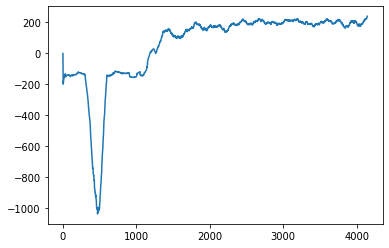

In [37]:
pd.Series(highscores).rolling(min_periods=1, window=100).mean().plot()

In [48]:
test_highscores = []

for i in range(1):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        env.render()
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        observation = next_observation
        score += reward
        
    test_highscores.append(score)
    
env.close()
test_highscores, np.mean(test_highscores)

([296.65767195162096], 296.65767195162096)